In [12]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score


In [13]:
df = pd.read_csv(r'C:\Users\eliya\OneDrive\Desktop\Data Science Projects\DS_salary_estimator\salary_data_post_EDA.csv')

In [14]:
#Small data cleaning
df = df.rename(columns={'aws_yn': 'aws',
                        'excel_yn': 'excel',
                        'tableau_yn': 'tableau',
                        'spark_yn': 'spark'})

In [15]:
df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer_provided', 'min_salary', 'max_salary', 'avg_salary',
       'company_txt', 'job_state', 'same_state', 'age', 'python_yn', 'r_yn',
       'spark', 'aws', 'excel', 'tableau', 'job_simp', 'seniority', 'desc_len',
       'num_comp'],
      dtype='object')

In [16]:
#Choose relevant columns
df_model = df[['avg_salary','Rating','Size','Type of ownership','Industry','Sector','Revenue','num_comp','hourly','employer_provided',
             'job_state','same_state','age','python_yn','spark','aws','excel','job_simp','seniority','desc_len']]
df_model.head()


,avg_salary,Rating,Size,Type of ownership,Industry,Sector,Revenue,num_comp,hourly,employer_provided,job_state,same_state,age,python_yn,spark,aws,excel,job_simp,seniority,desc_len
0,72.0,3.8,501 to 1000 employees,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),0,0,0,NM,0,50,1,0,0,1,data scientist,na,2536
1,87.5,3.4,10000+ employees,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),0,0,0,MD,0,39,1,0,0,0,data scientist,na,4783
2,85.0,4.8,501 to 1000 employees,Company - Private,Security Services,Business Services,$100 to $500 million (USD),0,0,0,FL,1,13,1,1,0,1,data scientist,na,3461
3,76.5,3.8,1001 to 5000 employees,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),3,0,0,WA,1,58,1,0,0,0,data scientist,na,3883
4,114.5,2.9,51 to 200 employees,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,3,0,0,NY,1,25,1,0,0,1,data scientist,na,2728


In [17]:
#Get dummy data for categorical values
df_dum = pd.get_dummies(df_model, columns=['Size', 'Type of ownership', 'Industry', 'Sector', 'Revenue'
                                           , 'job_state', 'job_simp', 'seniority'])
df_dum.head()


,avg_salary,Rating,num_comp,hourly,employer_provided,same_state,age,python_yn,spark,aws,...,job_simp_analyst,job_simp_data engineer,job_simp_data scientist,job_simp_director,job_simp_manager,job_simp_mle,job_simp_na,seniority_junior,seniority_na,seniority_senior
0,72.0,3.8,0,0,0,0,50,1,0,0,...,0,0,1,0,0,0,0,0,1,0
1,87.5,3.4,0,0,0,0,39,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2,85.0,4.8,0,0,0,1,13,1,1,0,...,0,0,1,0,0,0,0,0,1,0
3,76.5,3.8,3,0,0,1,58,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,114.5,2.9,3,0,0,1,25,1,0,0,...,0,0,1,0,0,0,0,0,1,0


In [18]:
#train test split
X = df_dum.drop('avg_salary', axis =1)
y = df_dum.avg_salary.values

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Normalizing the train data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 28584316728880.047


In [22]:
# Multiple linear regression 
X_sm = X = sm.add_constant(X)
model = sm.OLS(y,X_sm)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     10.21
Date:                Thu, 03 Aug 2023   Prob (F-statistic):           1.56e-94
Time:                        16:40:21   Log-Likelihood:                -3311.7
No. Observations:                 742   AIC:                             6909.
Df Residuals:                     599   BIC:                             7569.
Df Model:                         142                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
const                                                42.9016      6.385      6.719      0.000      30.362      55.441
Rating                                                3.6537      1.933      1.890      0.059      -0.142       7.449
num_comp                                              2.2549      0.869      2.595      0.010       0.548       3.962
hourly                                              -36.5066      9.191     -3.972      0.000     -54.558     -18.455
employer_provided                                    31.6415     11.510      2.749      0.006       9.037      54.246
same_state                                            2.4874      2.619      0.950      0.343      -2.656       7.631
age                                                   0.0339      0.030      1.127      0.260      -0.025       0.093
python_yn                                             8.1503      2.524      3.229      0.001       3.194      13.107
spark                                                -0.5557      2.920     -0.190      0.849      -6.291       5.180
aws                                                   1.1253      2.737      0.411      0.681      -4.250       6.500
excel                                                -0.4003      2.269     -0.176      0.860      -4.857       4.057
desc_len                                             -0.0001      0.001     -0.172      0.863      -0.002       0.001
Size_-1                                              13.5721      8.631      1.572      0.116      -3.379      30.523
Size_1 to 50 employees                                0.9733      6.489      0.150      0.881     -11.770      13.717
Size_10000+ employees                                -2.9581      5.799     -0.510      0.610     -14.347       8.430
Size_1001 to 5000 employees                           6.0637      3.876      1.564      0.118      -1.549      13.676
Size_201 to 500 employees                             2.1662      3.867      0.560      0.576      -5.428       9.761
Size_5001 to 10000 employees                         -3.9279      5.442     -0.722      0.471     -14.616       6.760
Size_501 to 1000 employees                            2.0004      4.048      0.494      0.621      -5.949       9.950
Size_51 to 200 employees                              4.0477      4.405      0.919      0.359      -4.604      12.699
Size_Unknown                                         20.9643     14.010      1.496      0.135      -6.550      48.478
Type of ownership_-1                                 13.5721      8.631      1.572      0.116      -3.379      30.523
Type of ownership_College / University                6.1971     17.727      0.350      0.727     -28.618      41.012
Type of ownersh

In [23]:
# Linear Regression Model
lm = LinearRegression()
lm.fit(X_train, y_train)
np.mean(cross_val_score(lm,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3))

-461338253485319.0

In [24]:
import warnings
warnings.filterwarnings('always')

c:\Users\eliya\Conda\ML_project_1\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.705e+02, tolerance: 5.683e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\eliya\Conda\ML_project_1\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.701e+02, tolerance: 5.722e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\eliya\Conda\ML_project_1\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularis

,alpha,error
64,0.65,-18.896809


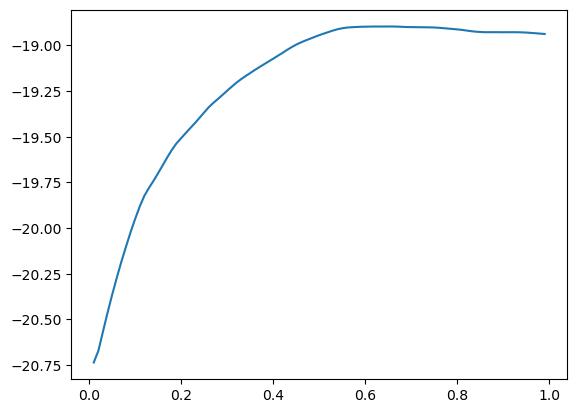

In [25]:
# lasso regression 
lm_l = Lasso(alpha=.65)
lm_l.fit(X_train,y_train)
np.mean(cross_val_score(lm_l,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3))

alpha = []
error = []

for i in range(1,100):
    alpha.append(i/100)
    lml = Lasso(alpha=(i/100))
    error.append(np.mean(cross_val_score(lml,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3)))
    
plt.plot(alpha,error)

err = tuple(zip(alpha,error))
df_err = pd.DataFrame(err, columns = ['alpha','error'])
df_err[df_err.error == max(df_err.error)]


In [26]:
# random forest 
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

np.mean(cross_val_score(rf,X_train,y_train,scoring = 'neg_mean_absolute_error', cv= 10))

-13.30170466101695

In [27]:
# tune models GridsearchCV 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Create a model
model = RandomForestRegressor()

# Create a dictionary of hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],  # number of trees
    'max_depth': [None, 10, 20, 30],  # maximum depth of the tree
    'min_samples_split': [2, 5, 10]  # minimum number of samples required to split a node
}

# Setup the grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error') 


# Fit the grid search to the data
grid_search.fit(X, y)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best model
best_model = grid_search.best_estimator_

print("Best parameters: ", best_params)
print("Best model: ", best_model)

c:\Users\eliya\Conda\ML_project_1\env\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\eliya\Conda\ML_project_1\env\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\eliya\Conda\ML_project_1\env\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Depreca

Best parameters:  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best model:  RandomForestRegressor(n_estimators=200)


In [30]:
# test ensembles
parameters = {'n_estimators':range(10,300,10), 'criterion':('mse','mae'), 'max_features':('auto','sqrt','log2')} 
gs = GridSearchCV(rf,parameters,scoring='neg_mean_absolute_error',cv=3)
gs.fit(X_train, y_train)
tpred_lm = lm.predict(X_test)
tpred_lml = lm_l.predict(X_test)
tpred_rf = gs.best_estimator_.predict(X_test)

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test,tpred_lm)
mean_absolute_error(y_test,tpred_lml)
mean_absolute_error(y_test,tpred_rf)

mean_absolute_error(y_test,(tpred_lm+tpred_rf)/2)

import pickle
pickl = {'model': gs.best_estimator_}
pickle.dump( pickl, open( 'model_file' + ".p", "wb" ) )

file_name = "model_file.p"
with open(file_name, 'rb') as pickled:
    data = pickle.load(pickled)
    model = data['model']

model.predict(np.array(list(X_test.iloc[1,:])).reshape(1,-1))[0]

list(X_test.iloc[1,:])

ValueError: 
All the 522 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
261 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eliya\Conda\ML_project_1\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eliya\Conda\ML_project_1\env\Lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "c:\Users\eliya\Conda\ML_project_1\env\Lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\eliya\Conda\ML_project_1\env\Lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'criterion' parameter of RandomForestRegressor must be a str among {'absolute_error', 'friedman_mse', 'poisson', 'squared_error'}. Got 'mse' instead.

--------------------------------------------------------------------------------
261 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\eliya\Conda\ML_project_1\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\eliya\Conda\ML_project_1\env\Lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "c:\Users\eliya\Conda\ML_project_1\env\Lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\eliya\Conda\ML_project_1\env\Lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'criterion' parameter of RandomForestRegressor must be a str among {'absolute_error', 'friedman_mse', 'poisson', 'squared_error'}. Got 'mae' instead.


### For conclusion:
### 1. Random Forest is the best model (the lowest MAE) for this dataset.
### 2. My second best model is lasso regression, but it's not as good as Random Forest.
### 3. I got serious misconfigured and normalizing problems with Linear Regression that I have to fix, so I didn't use it.